In [1]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud, STOPWORDS
import re
import string
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import stopwords
from collections import defaultdict
import torch
from tqdm import tqdm
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from PIL import Image
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
import warnings


warnings.filterwarnings('ignore', category=UserWarning, module='transformers')


%matplotlib inline

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Read Data

In [3]:
df=pd.read_csv("/kaggle/input/apps-reviews/apps_reviews.csv")

In [4]:
wordcloud_mask=np.array(Image.open("/kaggle/input/wordcloud-mask-collection/twitter.png"))

In [5]:
df.head()

userName                                          userImage  \
0     Andrew Thomas  https://lh3.googleusercontent.com/a-/AOh14GiHd...   
1      Craig Haines  https://lh3.googleusercontent.com/-hoe0kwSJgPQ...   
2     steven adkins  https://lh3.googleusercontent.com/a-/AOh14GiXw...   
3  Lars Panzerbjørn  https://lh3.googleusercontent.com/a-/AOh14Gg-h...   
4     Scott Prewitt  https://lh3.googleusercontent.com/-K-X1-YsVd6U...   

                                             content  score  thumbsUpCount  \
0  Update: After getting a response from the deve...      1             21   
1  Used it for a fair amount of time without any ...      1             11   
2  Your app sucks now!!!!! Used to be good but no...      1             17   
3  It seems OK, but very basic. Recurring tasks n...      1            192   
4  Absolutely worthless. This app runs a prohibit...      1             42   

  reviewCreatedVersion                   at  \
0             4.17.0.3  2020-04-05 22:25:57   
1             4.17.0.3  2020-04-04 13:40:01   
2             4.17.0.3  2020-04-01 16:18:13   
3             4.17.0.2  2020-03-12 08:17:34   
4             4.17.0.2  2020-03-14 17:41:01   

                                        replyContent            repliedAt  \
0  According to our TOS, and the term you have ag...  2020-04-05 15:10:24   
1  It sounds like you logged in with a different ...  2020-04-05 15:11:35   
2  This sounds odd! We are not aware of any issue...  2020-04-02 16:05:56   
3  We do offer this option as part of the Advance...  2020-03-15 06:20:13   
4  We're sorry you feel this way! 90% of the app ...  2020-03-15 23:45:51   

       sortOrder      appId  
0  most_relevant  com.anydo  
1  most_relevant  com.anydo  
2  most_relevant  com.anydo  
3  most_relevant  com.anydo  
4  most_relevant  com.anydo

# Data Exploration

In [6]:
df.shape

(15746, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


In [8]:
df.isnull().sum()

userName                   0
userImage                  0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    2213
at                         0
replyContent            8379
repliedAt               8379
sortOrder                  0
appId                      0
dtype: int64

In [9]:
df.drop(columns=["userName","userImage","thumbsUpCount","reviewCreatedVersion","at","repliedAt","sortOrder","appId"],axis=1,inplace=True)

In [10]:
df.head()

content  score  \
0  Update: After getting a response from the deve...      1   
1  Used it for a fair amount of time without any ...      1   
2  Your app sucks now!!!!! Used to be good but no...      1   
3  It seems OK, but very basic. Recurring tasks n...      1   
4  Absolutely worthless. This app runs a prohibit...      1   

                                        replyContent  
0  According to our TOS, and the term you have ag...  
1  It sounds like you logged in with a different ...  
2  This sounds odd! We are not aware of any issue...  
3  We do offer this option as part of the Advance...  
4  We're sorry you feel this way! 90% of the app ...

In [11]:
df["text"]=df["content"]+" "+df["replyContent"]

In [12]:
df.head()

content  score  \
0  Update: After getting a response from the deve...      1   
1  Used it for a fair amount of time without any ...      1   
2  Your app sucks now!!!!! Used to be good but no...      1   
3  It seems OK, but very basic. Recurring tasks n...      1   
4  Absolutely worthless. This app runs a prohibit...      1   

                                        replyContent  \
0  According to our TOS, and the term you have ag...   
1  It sounds like you logged in with a different ...   
2  This sounds odd! We are not aware of any issue...   
3  We do offer this option as part of the Advance...   
4  We're sorry you feel this way! 90% of the app ...   

                                                text  
0  Update: After getting a response from the deve...  
1  Used it for a fair amount of time without any ...  
2  Your app sucks now!!!!! Used to be good but no...  
3  It seems OK, but very basic. Recurring tasks n...  
4  Absolutely worthless. This app runs a prohibit...

In [13]:
df.drop(columns=["content","replyContent"],axis=1,inplace=True)

In [14]:
df.head()

score                                               text
0      1  Update: After getting a response from the deve...
1      1  Used it for a fair amount of time without any ...
2      1  Your app sucks now!!!!! Used to be good but no...
3      1  It seems OK, but very basic. Recurring tasks n...
4      1  Absolutely worthless. This app runs a prohibit...

In [15]:
df["text"][0]

"Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK. According to our TOS, and the term you have agreed to upon creating your free trial, after the 7 days, there is an automatic charge for the plan, unless you cancel prior to the renewal date. As you did not cancel the subscription in time, you were charged per this agreement."

In [16]:
df["score"].value_counts()

score
3    5042
5    2900
4    2776
1    2566
2    2462
Name: count, dtype: int64

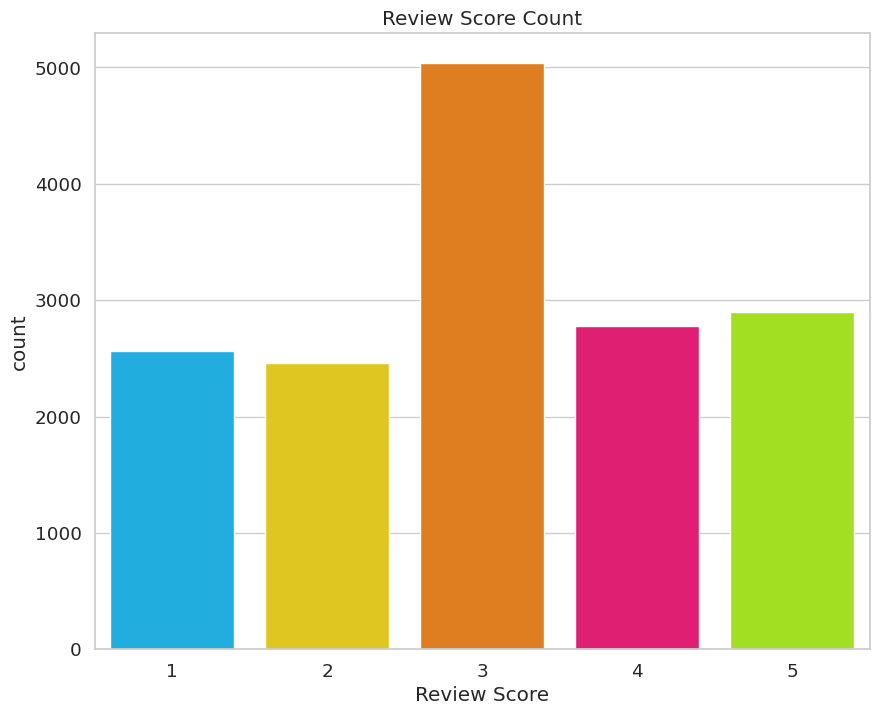

In [17]:
plt.figure(figsize=(10,8))
sns.countplot(x="score",data=df)
plt.xlabel("Review Score")
plt.title("Review Score Count")
plt.show()

### That's hugely imbalanced, but it's okay. We're going to convert the dataset into negative, neutral and positive sentiment:

# Define a function to categorize the sentiment based on the score

In [18]:
def categorize_sentiment(score):
    if score == 3:
        return 'Neutral'
    elif score in [1, 2]:
        return 'Negative'
    elif score in [4, 5]:
        return 'Positive'

df['sentiment'] = df['score'].apply(categorize_sentiment)

In [19]:
df.head()

score                                               text sentiment
0      1  Update: After getting a response from the deve...  Negative
1      1  Used it for a fair amount of time without any ...  Negative
2      1  Your app sucks now!!!!! Used to be good but no...  Negative
3      1  It seems OK, but very basic. Recurring tasks n...  Negative
4      1  Absolutely worthless. This app runs a prohibit...  Negative

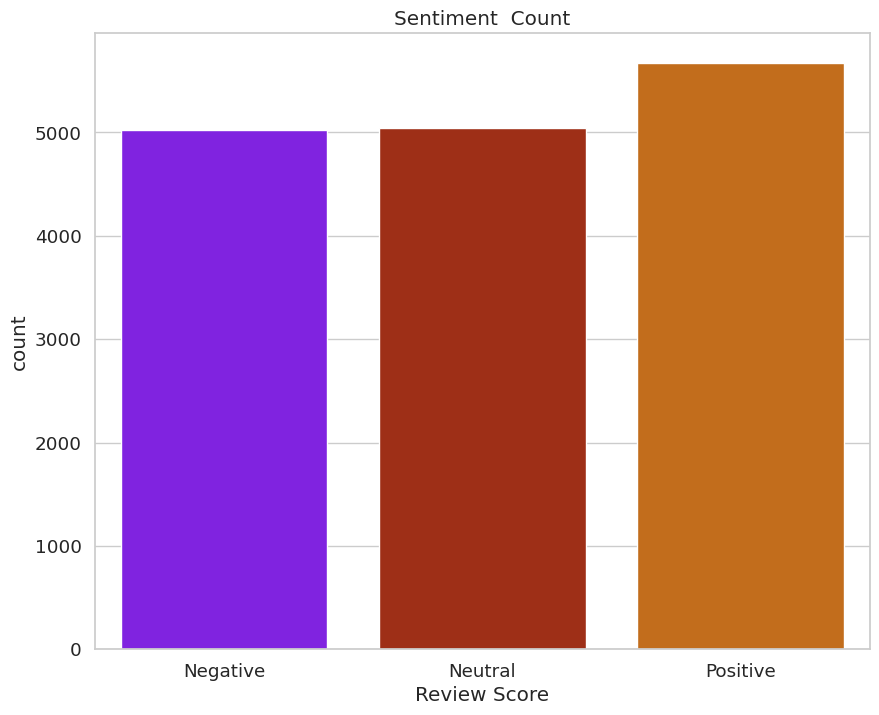

In [20]:
plt.figure(figsize=(10,8))
sns.countplot(x="sentiment",data=df,palette="gnuplot")
plt.xlabel("Review Score")
plt.title("Sentiment  Count")
plt.show()

# Clean Data

In [21]:


def clean_text(text):
    if isinstance(text, str):
        text = BeautifulSoup(text, 'html.parser').get_text()
        text = re.sub(r"[^a-zA-Z]", " ", text)
        text = text.translate(str.maketrans("", "", string.punctuation))

        emoji_pattern = re.compile("[" 
                                   u"\U0001F600-\U0001F64F" 
                                   u"\U0001F300-\U0001F5FF"  
                                   u"\U0001F680-\U0001F6FF"  
                                   u"\U0001F1E0-\U0001F1FF"  
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)

        text = re.sub(r"#.*", "", text)
        text = re.sub(r"/\*.*?\*/", "", text, flags=re.DOTALL)
        text = text.lower()

        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]

        text = ' '.join(tokens)

        return text
    else:
        return ""


In [22]:
df["text"]=df["text"].apply(clean_text)

/tmp/ipykernel_23/1090887269.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


In [23]:
df.head()

score                                               text sentiment
0      1  update getting response developer would change...  Negative
1      1  used fair amount time without problems suddenl...  Negative
2      1  app sucks used good update physically open clo...  Negative
3      1  seems ok basic recurring tasks need work actua...  Negative
4      1  absolutely worthless app runs prohibitively cl...  Negative

In [24]:
df.drop(columns=["score"],axis=1,inplace=True)

# Negative Text Length

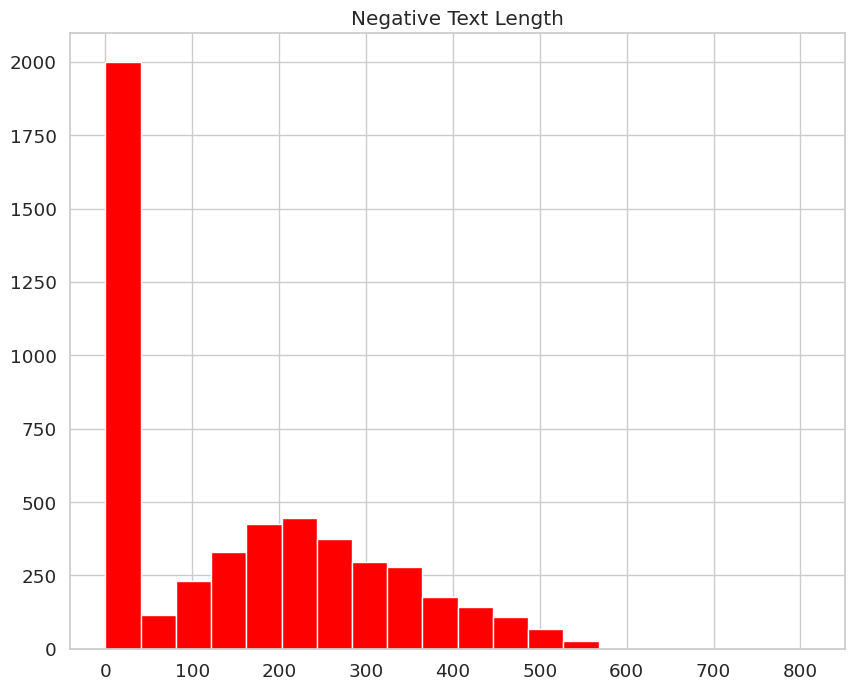

In [25]:
negative_text=df[df["sentiment"]=="Negative"]["text"].str.len()
plt.figure(figsize=(10,8))
plt.hist(negative_text, bins=20,label='Negative Text Length',color="red")
plt.title("Negative Text Length")
plt.show()

# Positive Text Length

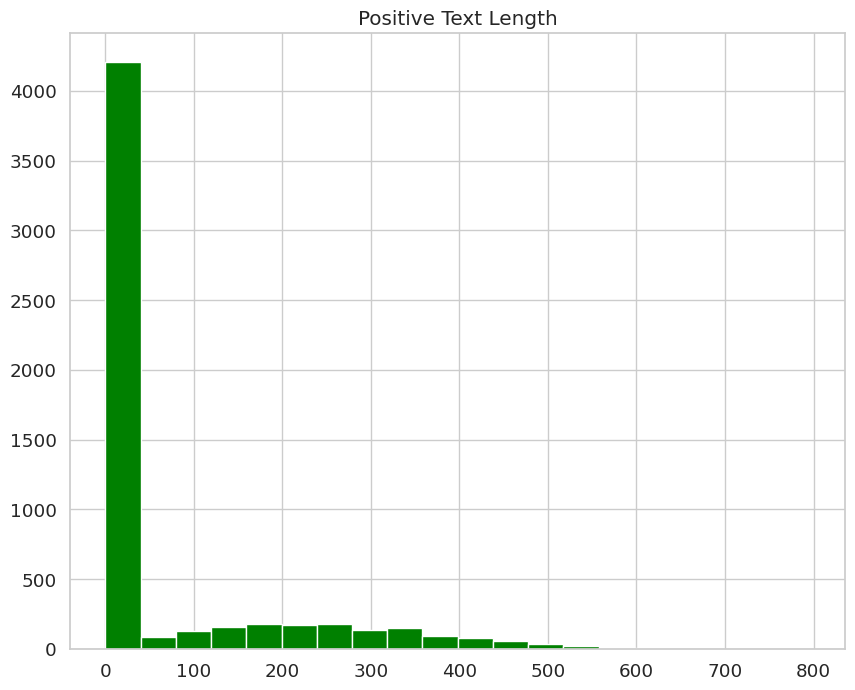

In [26]:
positive_text=df[df["sentiment"]=="Positive"]["text"].str.len()
plt.figure(figsize=(10,8))
plt.hist(positive_text, bins=20,label='Positive Text Length',color="green")
plt.title("Positive Text Length")
plt.show()

# Neutral Text Length

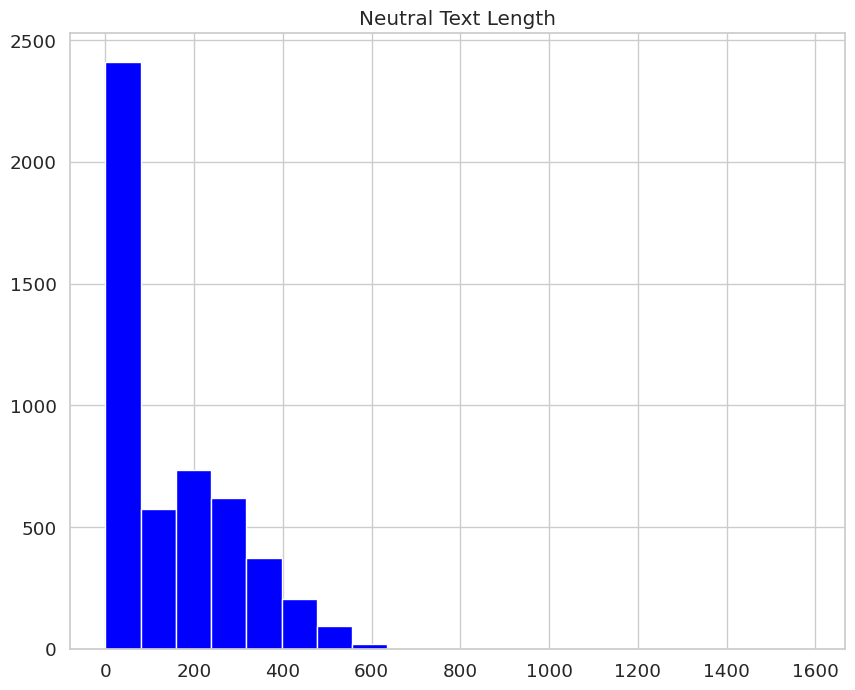

In [27]:
neutral_text=df[df["sentiment"]=="Neutral"]["text"].str.len()
plt.figure(figsize=(10,8))
plt.hist(neutral_text, bins=20,label='Neutral Text Length',color="blue")
plt.title("Neutral Text Length")
plt.show()

# Together

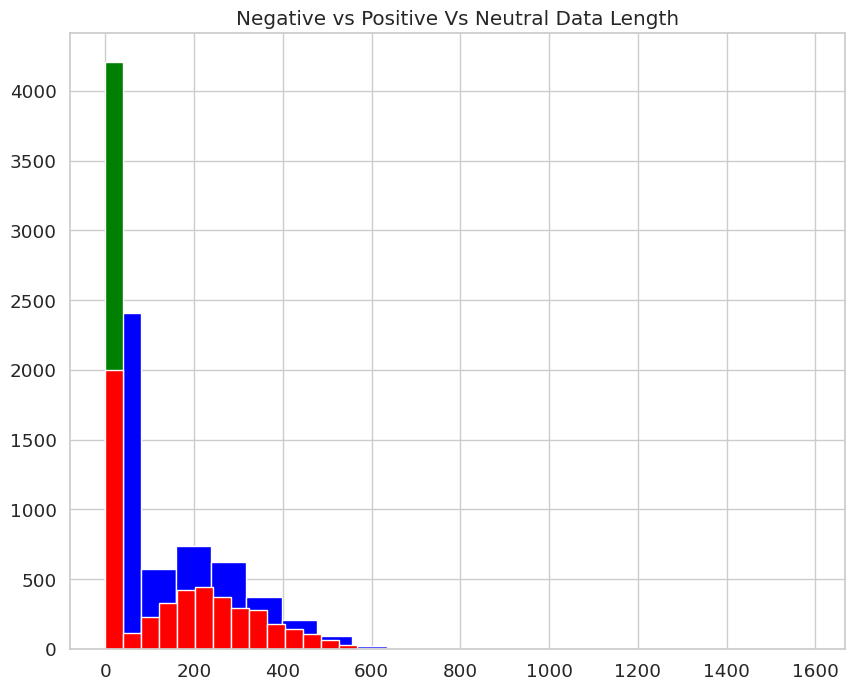

In [28]:
plt.figure(figsize=(10,8))
plt.hist(neutral_text, bins=20,label='Neutral Text Length',color="blue")
plt.hist(positive_text, bins=20,label='Positive Text Length',color="green")
plt.hist(negative_text, bins=20,label='Negative Text Length',color="red")
plt.title("Negative vs Positive Vs Neutral Data Length")
plt.show()

# Negative Data WordCloud

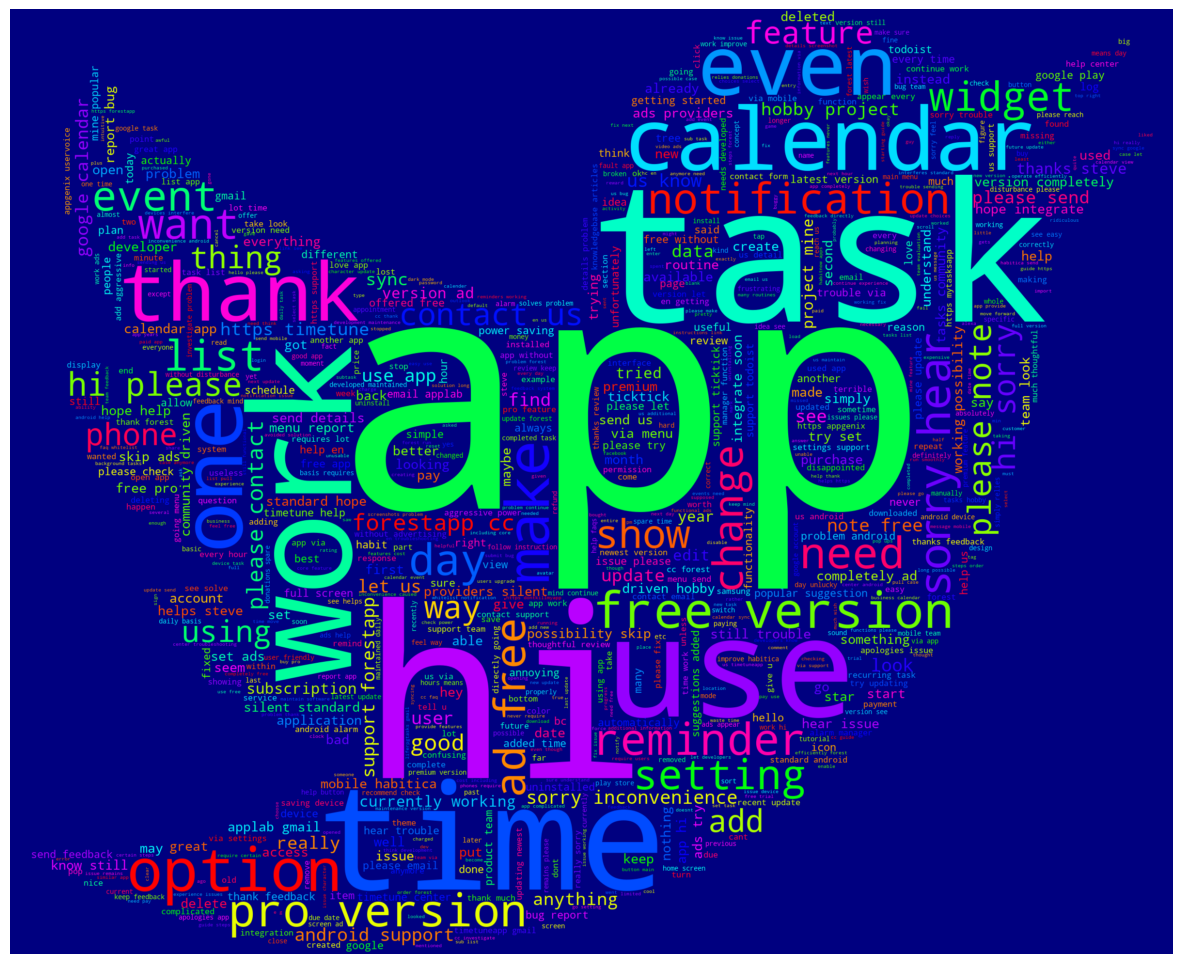

In [29]:


plt.figure(figsize=(15, 15))

negative_wordcloud = df[df["sentiment"] == "Negative"]
negative_text = " ".join(negative_wordcloud['text'].values.tolist())

wordcloud = WordCloud(width=800, height=800, stopwords=STOPWORDS, background_color='navy', 
                      max_words=800, colormap="hsv", mask=wordcloud_mask).generate(negative_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Positive Data Wordcloud

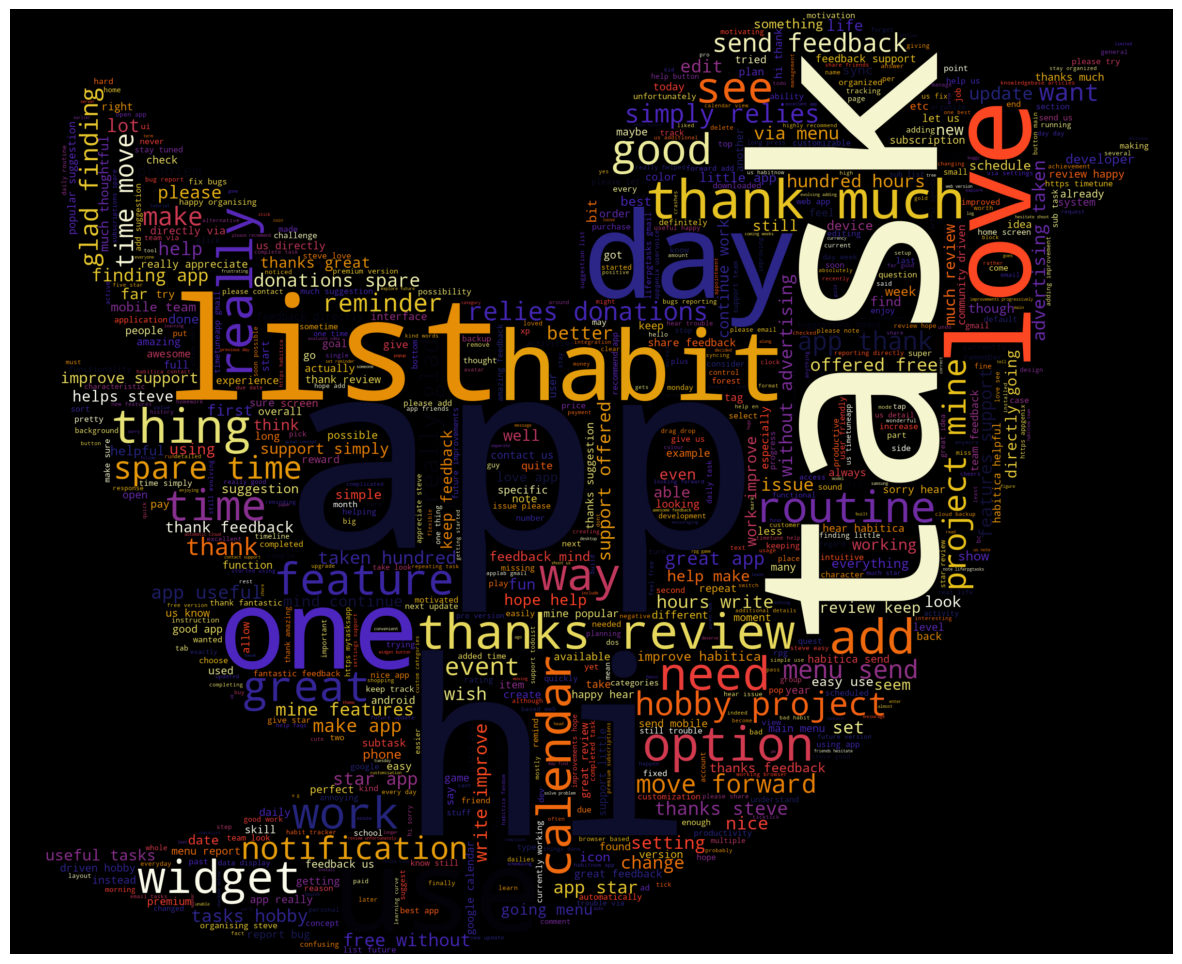

In [30]:
plt.figure(figsize=(15,15))
positive_wordcloud=df[df["sentiment"]=="Positive"]
positive_text=" ".join(positive_wordcloud['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="CMRmap",mask=wordcloud_mask).generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Neutral Data Wordcloud

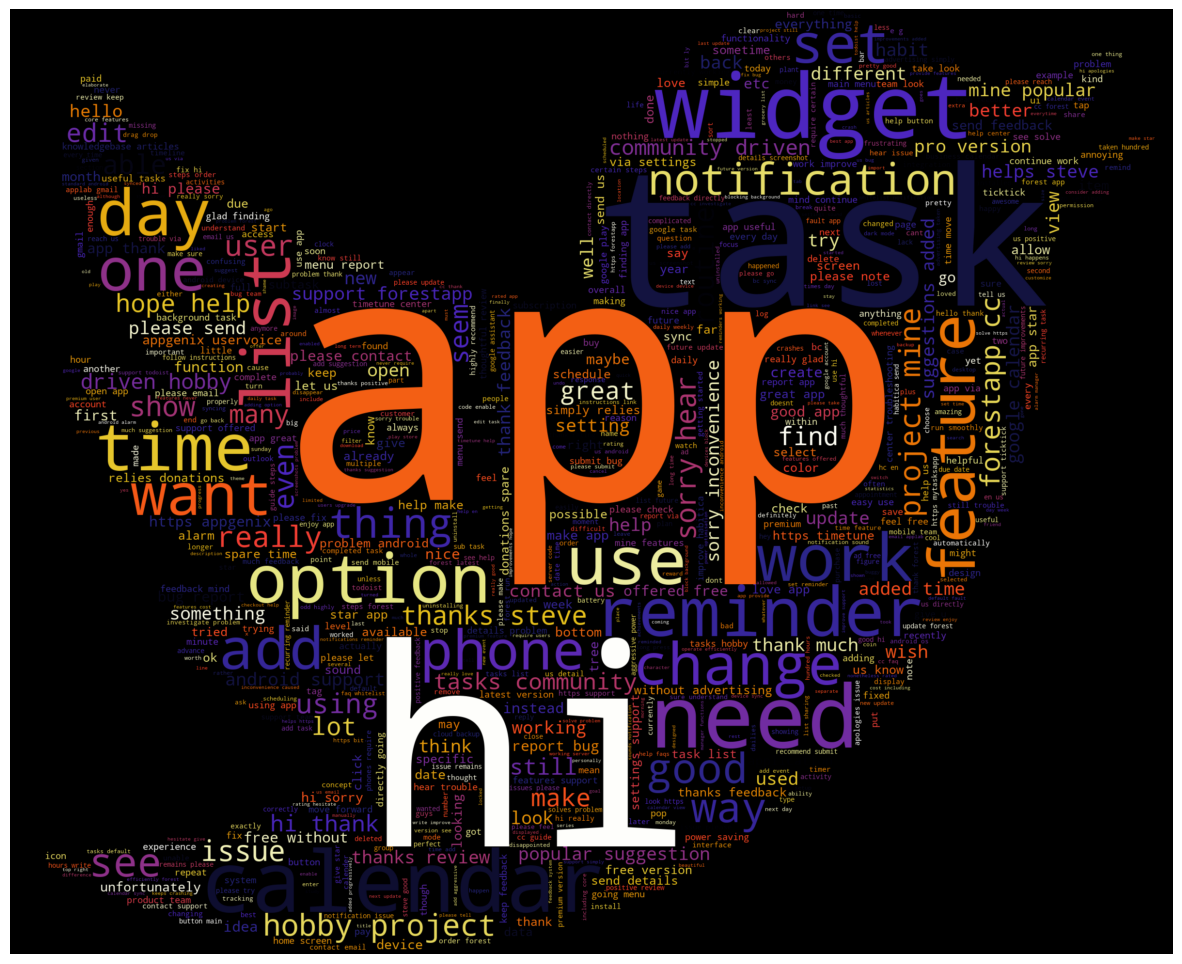

In [31]:
plt.figure(figsize=(15,15))
neutral_wordcloud=df[df["sentiment"]=="Neutral"]
neutral_text=" ".join(neutral_wordcloud['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="CMRmap",mask=wordcloud_mask).generate(neutral_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# ALL Data Wordcloud

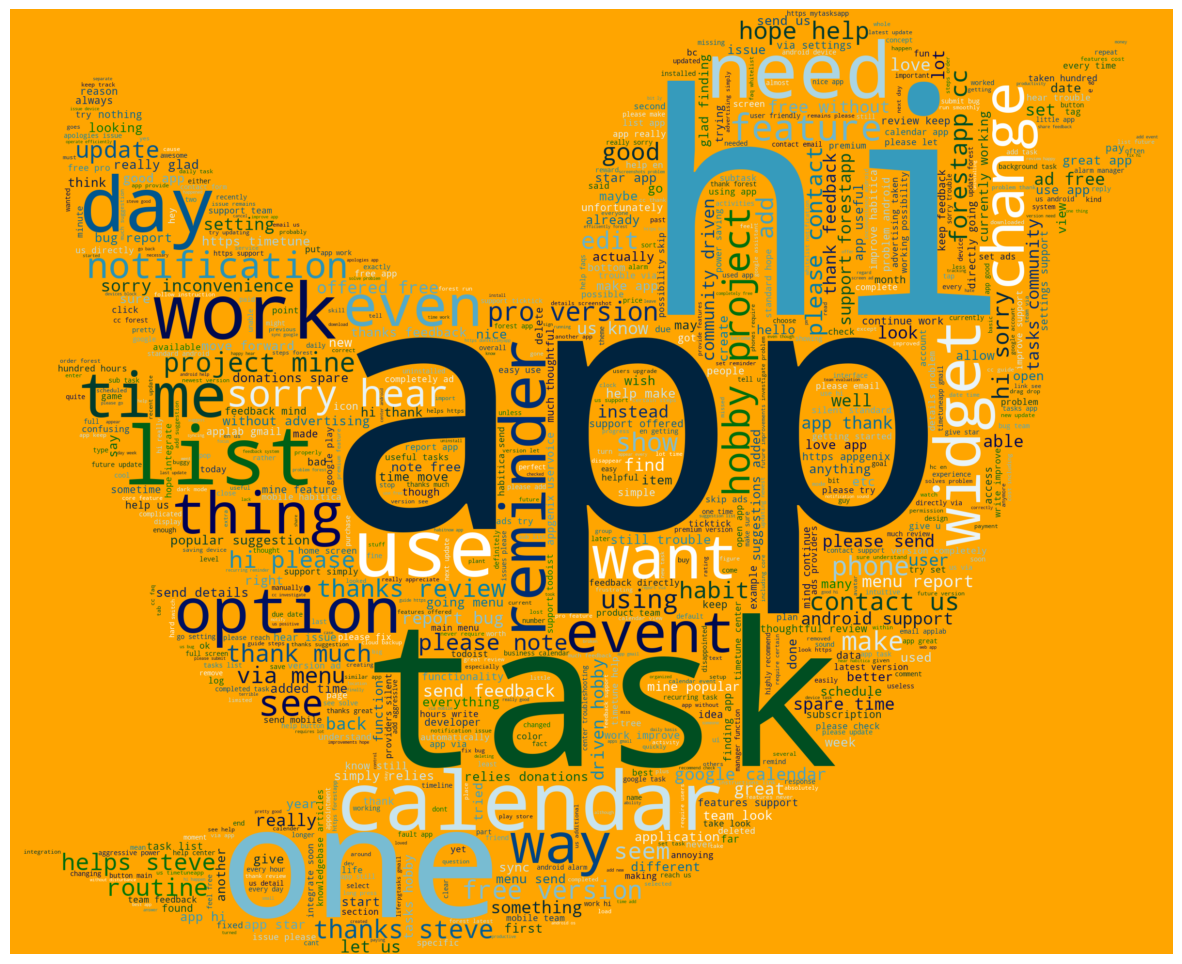

In [32]:
plt.figure(figsize=(15,15))
all_text=" ".join(df['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='orange', max_words=800,colormap="ocean",mask=wordcloud_mask).generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 30 Most common Words From All Text

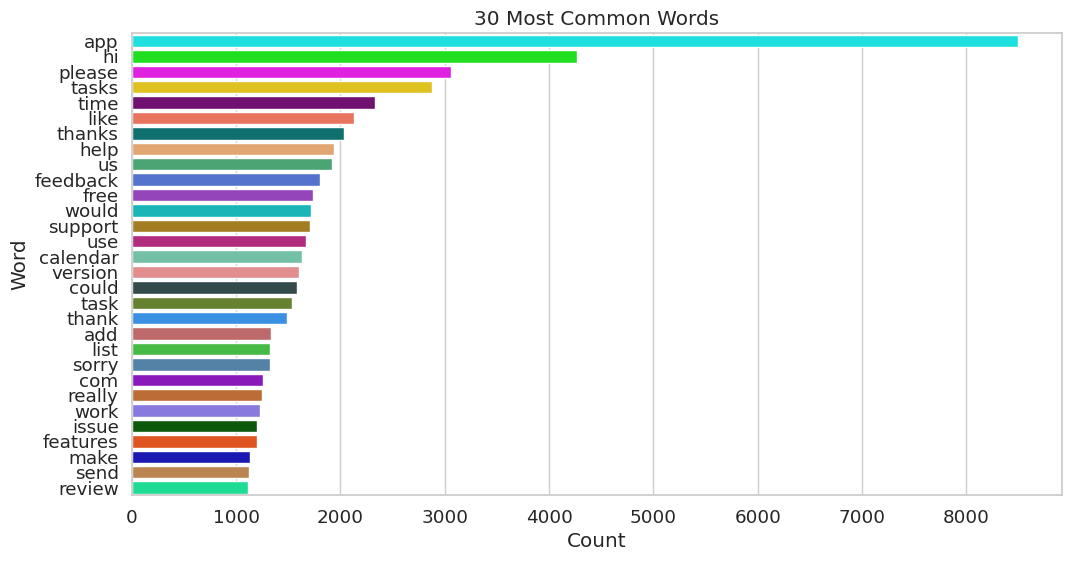

In [33]:
from itertools import chain
from collections import Counter

data_set =df["text"].str.split()
all_words = list(chain.from_iterable(data_set))
counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])

colors = ["cyan", "lime", "magenta", "gold", "purple", "tomato", "teal", "sandybrown", "mediumseagreen",
          "royalblue", "darkorchid", "darkturquoise", "darkgoldenrod", "mediumvioletred", "mediumaquamarine",
          "lightcoral", "darkslategray", "olivedrab", "dodgerblue", "indianred", "limegreen", "steelblue",
          "darkviolet", "chocolate", "mediumslateblue", "darkgreen", "orangered", "mediumblue", "peru", "mediumspringgreen"]

plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=df_common_words, palette=colors)
plt.title('30 Most Common Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

# Most Common Words From Negative Text

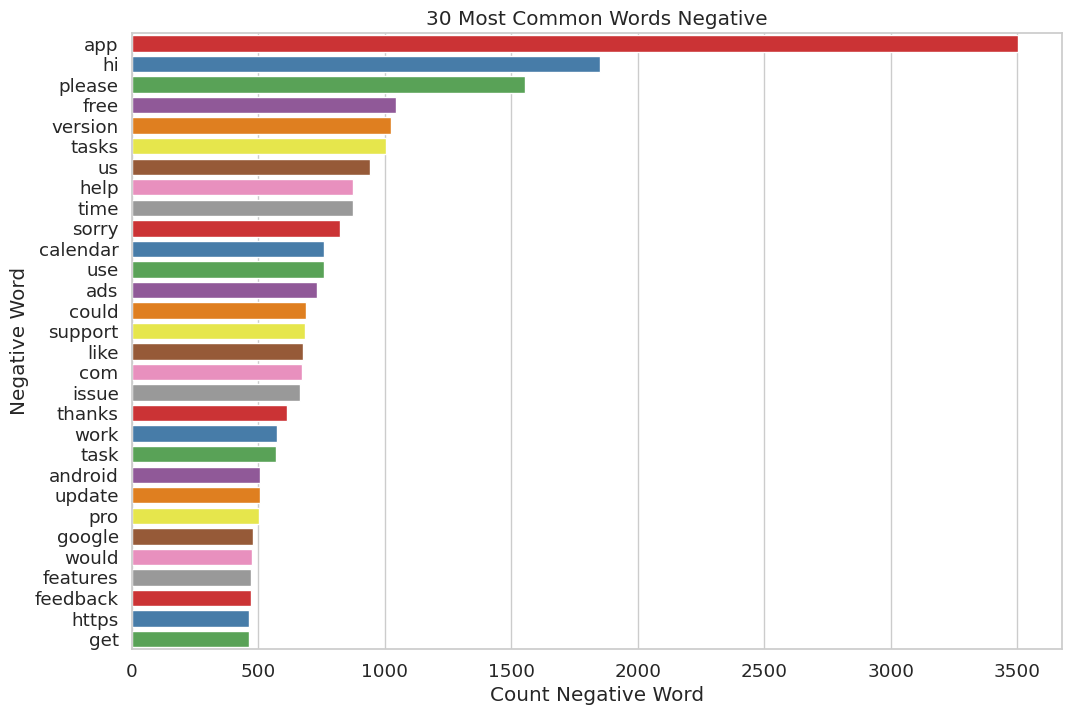

In [34]:
negative_text = df[df["sentiment"] == "Negative"]
data_set = negative_text["text"].str.split()
all_words = [word for sublist in data_set for word in sublist]
counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=df_common_words,palette="Set1")
plt.title('30 Most Common Words Negative')
plt.xlabel('Count Negative Word')
plt.ylabel('Negative Word')
plt.show()

# Most Common Words From Positive Text

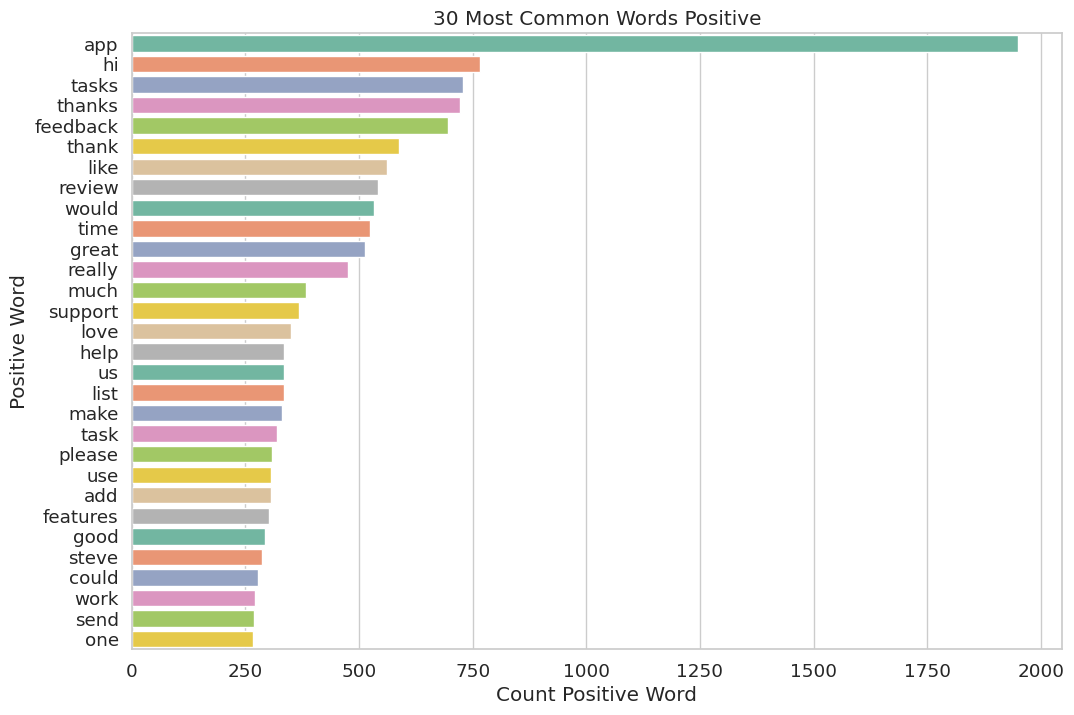

In [35]:
positive_text = df[df["sentiment"] == "Positive"]
data_set = positive_text["text"].str.split()
all_words = [word for sublist in data_set for word in sublist]
counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=df_common_words,palette="Set2")
plt.title('30 Most Common Words Positive')
plt.xlabel('Count Positive Word')
plt.ylabel('Positive Word')
plt.show()

# Most Common Words From Neutral Text

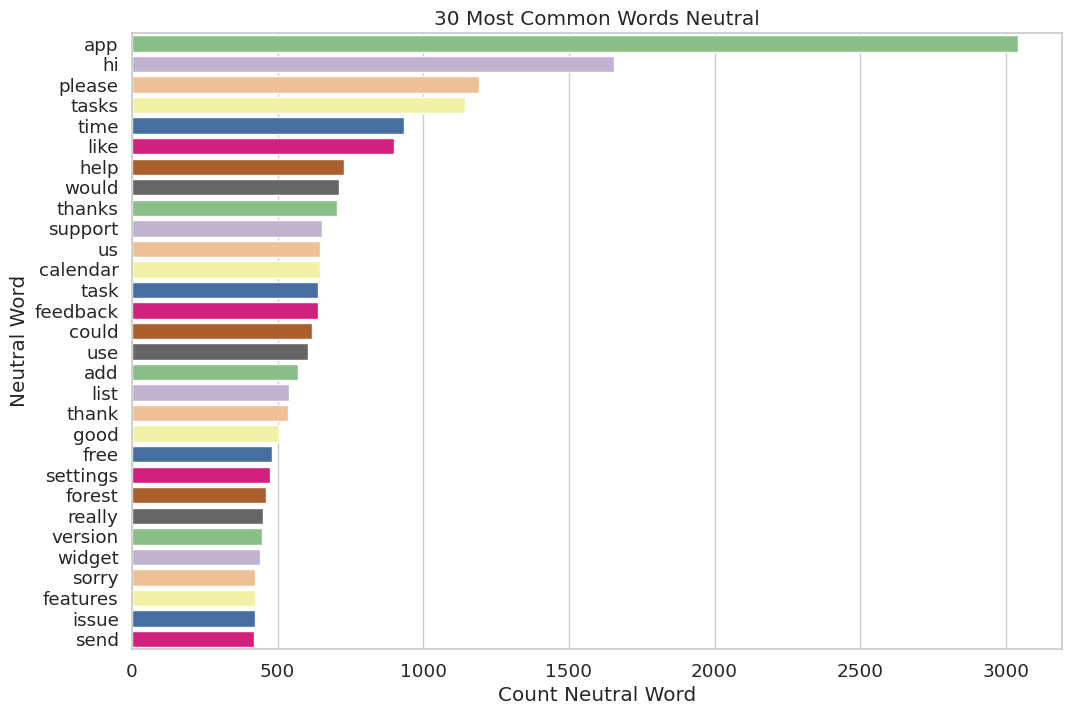

In [36]:
neutral_text = df[df["sentiment"] == "Neutral"]
data_set = neutral_text["text"].str.split()
all_words = [word for sublist in data_set for word in sublist]
counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=df_common_words,palette="Accent")
plt.title('30 Most Common Words Neutral')
plt.xlabel('Count Neutral Word')
plt.ylabel('Neutral Word')
plt.show()

In [37]:
df.head()

text sentiment
0  update getting response developer would change...  Negative
1  used fair amount time without problems suddenl...  Negative
2  app sucks used good update physically open clo...  Negative
3  seems ok basic recurring tasks need work actua...  Negative
4  absolutely worthless app runs prohibitively cl...  Negative

In [38]:
class_names = ['Negative', 'Positive', 'Neutral']

In [39]:
sentiment_map={"Negative":0,"Positive":1,"Neutral":2}
df["sentiment"]=df["sentiment"].replace(sentiment_map)

/tmp/ipykernel_23/3901681617.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["sentiment"]=df["sentiment"].replace(sentiment_map)


In [40]:
df.head()

text  sentiment
0  update getting response developer would change...          0
1  used fair amount time without problems suddenl...          0
2  app sucks used good update physically open clo...          0
3  seems ok basic recurring tasks need work actua...          0
4  absolutely worthless app runs prohibitively cl...          0

# Calculate the length of each text entry

In [41]:

df['text_length'] = df['text'].apply(len)


average_text_length = df['text_length'].mean()

print(f"Average Text Length: {average_text_length:.2f}")


Average Text Length: 116.94


In [42]:
df.drop(columns=["text_length"],axis=1,inplace=True)

# Load Bert Model

In [43]:
from transformers import BertModel,BertTokenizer
import torch

bert_model = BertModel.from_pretrained("bert-base-uncased", torch_dtype=torch.float16, attn_implementation="sdpa")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [44]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# We'll use this text to understand the tokenization process:

In [45]:
sample_text="update getting response developer would change rating stars possible guys hide behind confusing opaque terms refuse budge annoyed money lost really terrible customer experience original careful signing free trial app happen go automatically charge full years subscription refuse refund terrible customer experience app ok according tos term agreed upon creating free trial days automatic charge plan unless cancel prior renewal date cancel subscription time charged per agreement"

### Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [46]:
tokens = bert_tokenizer.tokenize(sample_text)
token_ids = bert_tokenizer.convert_tokens_to_ids(tokens)

print("================================================================================================")

print(f'Sentence: {sample_text}')
print("================================================================================================")
print(f'Tokens: {tokens}')
print("================================================================================================")
print(f'Token IDs: {token_ids}')
print("================================================================================================")

Sentence: update getting response developer would change rating stars possible guys hide behind confusing opaque terms refuse budge annoyed money lost really terrible customer experience original careful signing free trial app happen go automatically charge full years subscription refuse refund terrible customer experience app ok according tos term agreed upon creating free trial days automatic charge plan unless cancel prior renewal date cancel subscription time charged per agreement
Tokens: ['update', 'getting', 'response', 'developer', 'would', 'change', 'rating', 'stars', 'possible', 'guys', 'hide', 'behind', 'confusing', 'opaque', 'terms', 'refuse', 'budge', 'annoyed', 'money', 'lost', 'really', 'terrible', 'customer', 'experience', 'original', 'careful', 'signing', 'free', 'trial', 'app', 'happen', 'go', 'automatically', 'charge', 'full', 'years', 'subscription', 'refuse', 'ref', '##und', 'terrible', 'customer', 'experience', 'app', 'ok', 'according', 'to', '##s', 'term', 'agreed

### Special Tokens

`[SEP]` - marker for ending of a sentence

In [47]:
bert_tokenizer.sep_token, bert_tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [48]:
bert_tokenizer.cls_token, bert_tokenizer.cls_token_id

('[CLS]', 101)

### There is also a special token for padding:

In [49]:
bert_tokenizer.pad_token, bert_tokenizer.pad_token_id

('[PAD]', 0)

### BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [50]:
bert_tokenizer.unk_token, bert_tokenizer.unk_token_id

('[UNK]', 100)

In [51]:
encoding = bert_tokenizer.encode_plus(
  sample_text,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [52]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

# The token ids are now stored in a Tensor and padded to a length of 32:

In [53]:
print(len(encoding['input_ids'][0]))
print("===================================================================================================")
print(encoding['input_ids'][0])

32
tensor([  101, 10651,  2893,  3433,  9722,  2052,  2689,  5790,  3340,  2825,
         4364,  5342,  2369, 16801, 28670,  3408, 10214, 24981, 11654,  2769,
         2439,  2428,  6659,  8013,  3325,  2434,  6176,  6608,  2489,  3979,
        10439,   102])


# The attention mask has the same length:

In [54]:
print(len(encoding['attention_mask'][0]))
print("===================================================================================================")
print(encoding['attention_mask'][0])

32
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


# We can inverse the tokenization to have a look at the special tokens:

In [55]:
bert_tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'update',
 'getting',
 'response',
 'developer',
 'would',
 'change',
 'rating',
 'stars',
 'possible',
 'guys',
 'hide',
 'behind',
 'confusing',
 'opaque',
 'terms',
 'refuse',
 'budge',
 'annoyed',
 'money',
 'lost',
 'really',
 'terrible',
 'customer',
 'experience',
 'original',
 'careful',
 'signing',
 'free',
 'trial',
 'app',
 '[SEP]']

# Choosing Sequence Length
#### 
BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [56]:
token_lens = []

for txt in df.text:
  tokens = bert_tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

# plot the distribution using boxplot

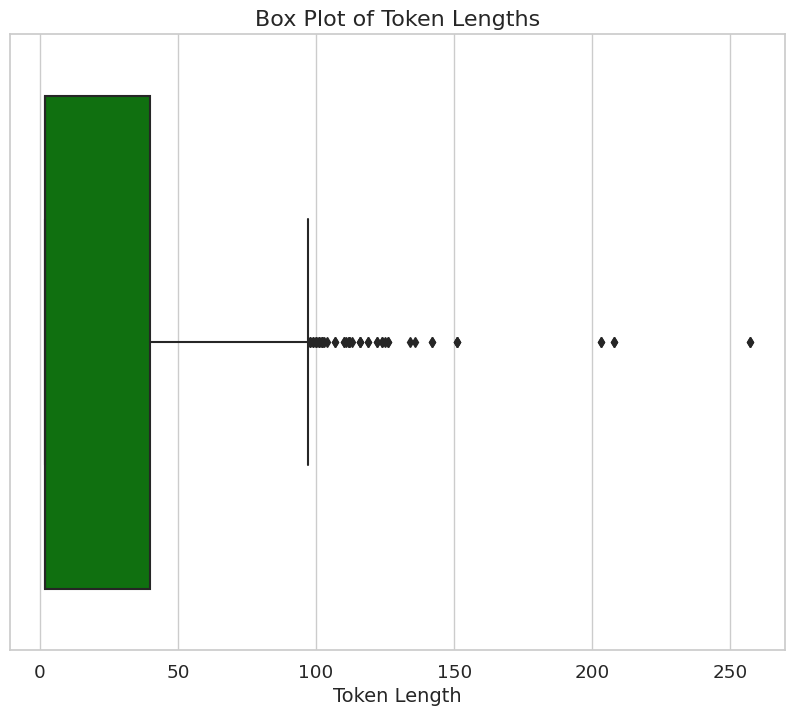

In [57]:
plt.figure(figsize=(10, 8))
sns.boxplot(x=token_lens, color='green')

plt.title('Box Plot of Token Lengths', fontsize=16)
plt.xlabel('Token Length', fontsize=14)
plt.show()

# plot the distribution using histplot

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


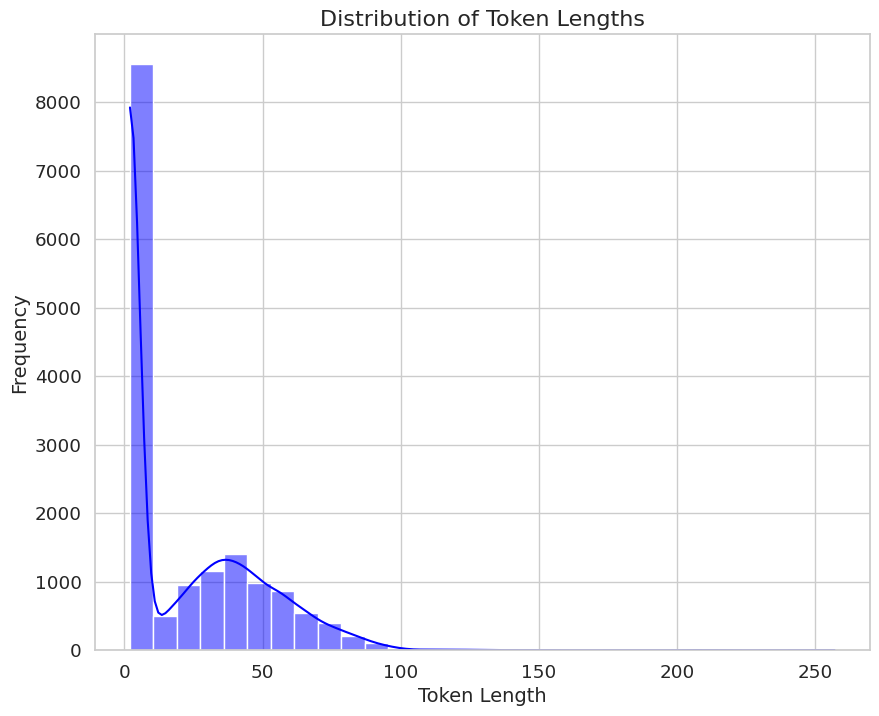

In [58]:
plt.figure(figsize=(10, 8))
sns.histplot(token_lens, bins=30, kde=True, color='blue')
plt.title('Distribution of Token Lengths', fontsize=16)
plt.xlabel('Token Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

# Calculate min, max, and average

In [59]:
import statistics


min_length = min(token_lens)
max_length = max(token_lens)
avg_length = statistics.mean(token_lens)

print("==============================================================================")
print(f"Minimum Token Length: {min_length}")
print("==============================================================================")
print(f"Maximum Token Length: {max_length}")
print("==============================================================================")
print(f"Average Token Length: {avg_length:.2f}")
print("==============================================================================")


Minimum Token Length: 2
Maximum Token Length: 257
Average Token Length: 21.42


# Maxlen==170

In [60]:
max_len=170

In [61]:
df.head()

text  sentiment
0  update getting response developer would change...          0
1  used fair amount time without problems suddenl...          0
2  app sucks used good update physically open clo...          0
3  seems ok basic recurring tasks need work actua...          0
4  absolutely worthless app runs prohibitively cl...          0

# Create Pytorch Dataset

In [62]:
from torch.utils.data import Dataset
import torch

class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',  # Ensure padding to max_len
            return_token_type_ids=False,
            return_attention_mask=True,
            truncation=True,  # Make sure long reviews are truncated to max_len
            return_tensors='pt',  # Return as PyTorch tensors
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),  # Flatten to remove unnecessary dimensions
            'attention_mask': encoding['attention_mask'].flatten(),  # Flatten the attention mask
            'targets': torch.tensor(target, dtype=torch.long)  # Convert the target to a tensor
        }


#### The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [63]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [64]:
df_train.shape, df_val.shape, df_test.shape

((12596, 2), (1575, 2), (1575, 2))

## We also need to create a couple of data loaders. Here's a helper function to do it:

In [65]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [66]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, bert_tokenizer,max_len, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, bert_tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, bert_tokenizer,max_len, BATCH_SIZE)

### Let's have a look at an example batch from our training data loader:

In [67]:
data = next(iter(train_data_loader))
data.keys()

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [68]:
print("##############################################################################")
print(data['input_ids'].shape)
print("##############################################################################")
print(data['attention_mask'].shape)
print("##############################################################################")
print(data['targets'].shape)
print("##############################################################################")

##############################################################################
torch.Size([16, 170])
##############################################################################
torch.Size([16, 170])
##############################################################################
torch.Size([16])
##############################################################################


# And try to use it on the encoding of our sample text:

In [69]:
bert_model = BertModel.from_pretrained("bert-base-uncased")

In [70]:
print(encoding)

{'input_ids': tensor([[  101, 10651,  2893,  3433,  9722,  2052,  2689,  5790,  3340,  2825,
          4364,  5342,  2369, 16801, 28670,  3408, 10214, 24981, 11654,  2769,
          2439,  2428,  6659,  8013,  3325,  2434,  6176,  6608,  2489,  3979,
         10439,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])}


In [71]:
output = bert_model(input_ids=encoding['input_ids'],attention_mask=encoding['attention_mask'])
last_hidden_state=output.last_hidden_state

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [72]:
last_hidden_state.shape

torch.Size([1, 32, 768])

### We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [73]:
bert_model.config.hidden_size

768

### You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [74]:
pooled_output = last_hidden_state[:, 0] 
pooled_output.shape

torch.Size([1, 768])

# We can use all of this knowledge to create a classifier that uses the BERT model:

In [75]:
import torch.nn as nn
from transformers import BertModel

class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)


In [76]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

# We'll move the example batch of our training data to the GPU:

In [77]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 170])
torch.Size([16, 170])


### To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [78]:
import torch.nn.functional as F
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4279, 0.3012, 0.2709],
        [0.3276, 0.3455, 0.3269],
        [0.3777, 0.2953, 0.3270],
        [0.4202, 0.3139, 0.2658],
        [0.2663, 0.4125, 0.3211],
        [0.2609, 0.2823, 0.4568],
        [0.2940, 0.3957, 0.3103],
        [0.5061, 0.3085, 0.1854],
        [0.4150, 0.3252, 0.2598],
        [0.2676, 0.3365, 0.3960],
        [0.2929, 0.3542, 0.3529],
        [0.2969, 0.3734, 0.3297],
        [0.4226, 0.2996, 0.2779],
        [0.4588, 0.3666, 0.1746],
        [0.4635, 0.2999, 0.2366],
        [0.3229, 0.3616, 0.3156]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

#### To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [79]:
from transformers import AdamW, get_linear_schedule_with_warmup

EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3,####  4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accur### acy.

Let's continue with writing a helper function for training our model for one epoch:

In [80]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader, desc="Training", leave=False):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

#### Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

In [81]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

### Using those two, we can write our training loop. We'll also store the training history:

In [82]:
EPOCHS = 20
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val loss: {val_loss:.4f} | Val accuracy: {val_acc:.4f}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

print("Training complete!")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

Epoch 1/20
----------


Train loss: 0.9913 | Train accuracy: 0.5059


Val loss: 0.9387 | Val accuracy: 0.5537

Epoch 2/20
----------


Train loss: 0.8749 | Train accuracy: 0.5942


Val loss: 0.9033 | Val accuracy: 0.5994

Epoch 3/20
----------


Train loss: 0.7727 | Train accuracy: 0.6512


Val loss: 0.9030 | Val accuracy: 0.6108

Epoch 4/20
----------


Train loss: 0.7045 | Train accuracy: 0.6839


Val loss: 0.9356 | Val accuracy: 0.6343

Epoch 5/20
----------


Train loss: 0.6578 | Train accuracy: 0.7026


Val loss: 0.9368 | Val accuracy: 0.6419

Epoch 6/20
----------


Train loss: 0.6217 | Train accuracy: 0.7139


Val loss: 0.9282 | Val accuracy: 0.6451

Epoch 7/20
----------


Train loss: 0.5987 | Train accuracy: 0.7199


Val loss: 0.9851 | Val accuracy: 0.6514

Epoch 8/20
----------


Train loss: 0.5814 | Train accuracy: 0.7246


Val loss: 0.9947 | Val accuracy: 0.6559

Epoch 9/20
----------


Train loss: 0.5764 | Train accuracy: 0.7257


Val loss: 1.0183 | Val accuracy: 0.6540

Epoch 10/20
----------


Train loss: 0.5694 | Train accuracy: 0.7275


Val loss: 1.0273 | Val accuracy: 0.6514

Epoch 11/20
----------


Train loss: 0.5666 | Train accuracy: 0.7286


Val loss: 1.0273 | Val accuracy: 0.6514

Epoch 12/20
----------


Train loss: 0.5648 | Train accuracy: 0.7290


Val loss: 1.0273 | Val accuracy: 0.6514

Epoch 13/20
----------


Train loss: 0.5654 | Train accuracy: 0.7290


Val loss: 1.0273 | Val accuracy: 0.6514

Epoch 14/20
----------


Train loss: 0.5659 | Train accuracy: 0.7289


Val loss: 1.0273 | Val accuracy: 0.6514

Epoch 15/20
----------


Train loss: 0.5645 | Train accuracy: 0.7290


Val loss: 1.0273 | Val accuracy: 0.6514

Epoch 16/20
----------


Train loss: 0.5651 | Train accuracy: 0.7291


Val loss: 1.0273 | Val accuracy: 0.6514

Epoch 17/20
----------


Train loss: 0.5651 | Train accuracy: 0.7290


Val loss: 1.0273 | Val accuracy: 0.6514

Epoch 18/20
----------


Train loss: 0.5660 | Train accuracy: 0.7290


Val loss: 1.0273 | Val accuracy: 0.6514

Epoch 19/20
----------


Train loss: 0.5675 | Train accuracy: 0.7286


Val loss: 1.0273 | Val accuracy: 0.6514

Epoch 20/20
----------


Train loss: 0.5650 | Train accuracy: 0.7286


Val loss: 1.0273 | Val accuracy: 0.6514

Training complete!
Best Validation Accuracy: 0.6559


# Training Metrics Visualization

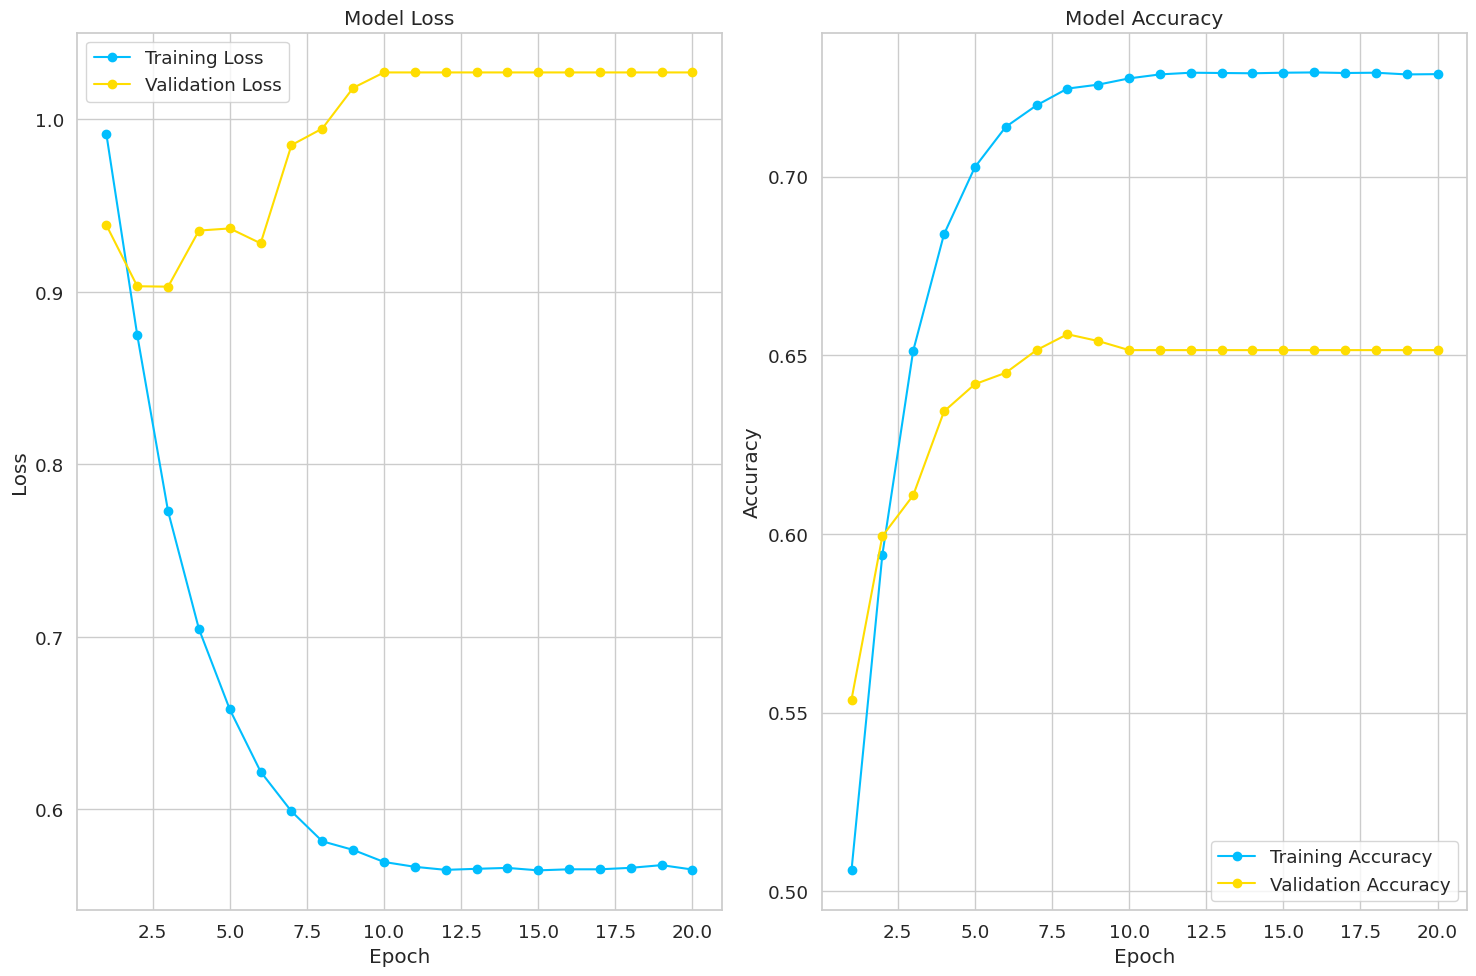

In [83]:


def plot_training_metrics(history):
    sns.set_style("whitegrid")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    train_loss = [loss.cpu().numpy() if hasattr(loss, 'cpu') else loss for loss in history['train_loss']]
    val_loss = [loss.cpu().numpy() if hasattr(loss, 'cpu') else loss for loss in history['val_loss']]
    train_acc = [acc.cpu().numpy() if hasattr(acc, 'cpu') else acc for acc in history['train_acc']]
    val_acc = [acc.cpu().numpy() if hasattr(acc, 'cpu') else acc for acc in history['val_acc']]
    
    ax1.plot(epochs, train_loss, marker='o', label='Training Loss')
    ax1.plot(epochs, val_loss, marker='o', label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(epochs, train_acc, marker='o', label='Training Accuracy')
    ax2.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_training_metrics(history)

## Evaluation
#### 
So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [84]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6565079365079365


### The accuracy is about 1% lower on the test set. Our model seems to generalize well.
#### 
We'll define a helper function to get the predictions from our mode
l:

In [85]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

```
This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):
```

In [86]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_data_loader)

# Classification Report

In [87]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    accuracy_score,
)
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.92      0.50      0.64       519
    Positive       0.56      0.95      0.70       590
     Neutral       0.73      0.46      0.57       466

    accuracy                           0.66      1575
   macro avg       0.74      0.64      0.64      1575
weighted avg       0.73      0.66      0.64      1575



# Confusion Matrix

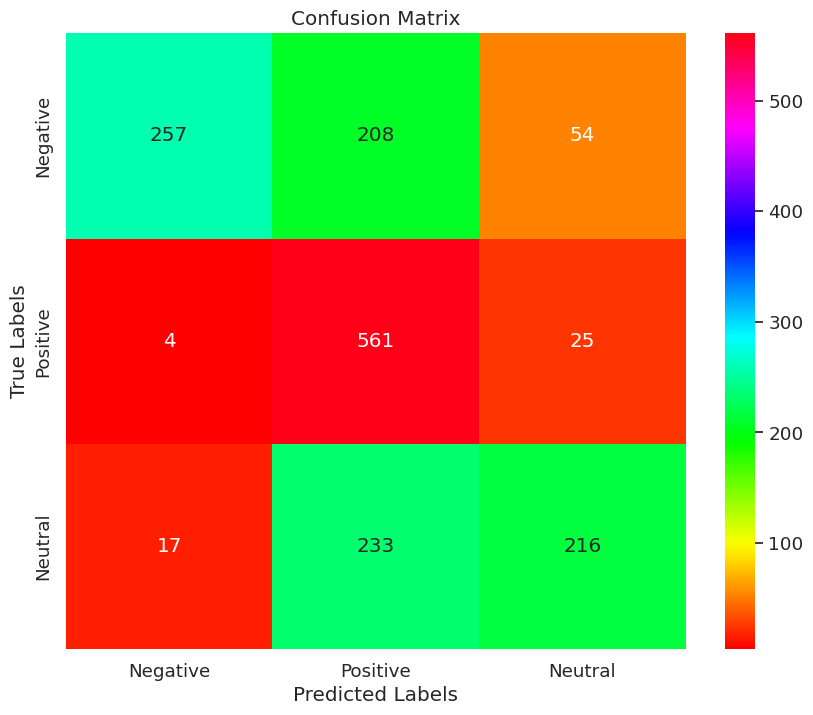

In [88]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='hsv', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#  Roc Curve

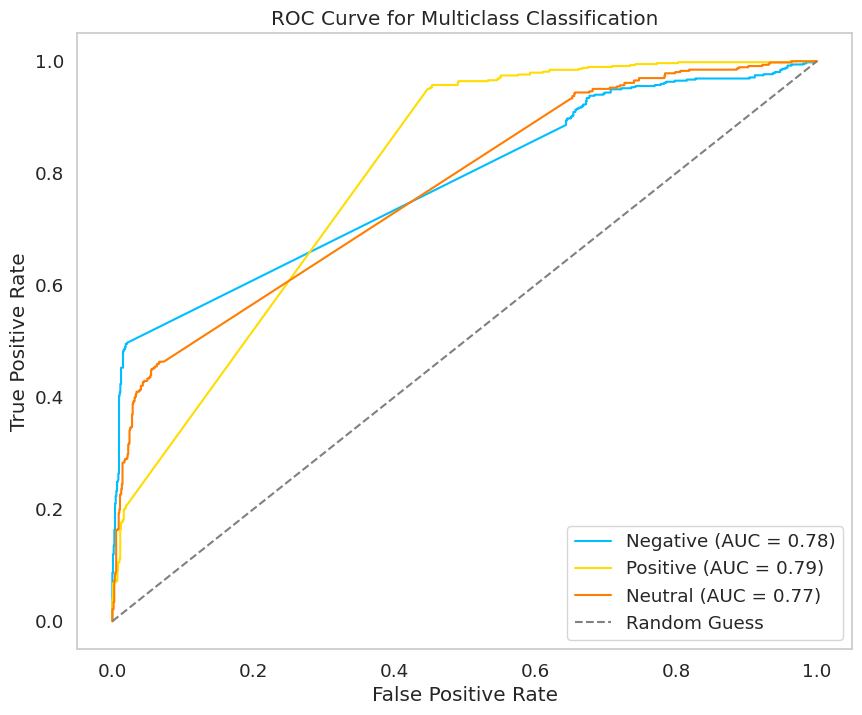

In [89]:
plt.figure(figsize=(10,8))

class_names = ['Negative', 'Positive', 'Neutral']
y_test_binarized = label_binarize(y_test, classes=range(len(class_names)))

for i, class_name in enumerate(class_names):
    if np.sum(y_test_binarized[:, i]) > 0 and np.sum(1 - y_test_binarized[:, i]) > 0:
        fpr, tpr, thresholds = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
        auc_score = roc_auc_score(y_test_binarized[:, i], y_pred_probs[:, i])
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc_score:.2f})")
    else:
        print(f"Skipping {class_name} because only one class is present in y_test.")



plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multiclass Classification")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# Precision Recall Curve

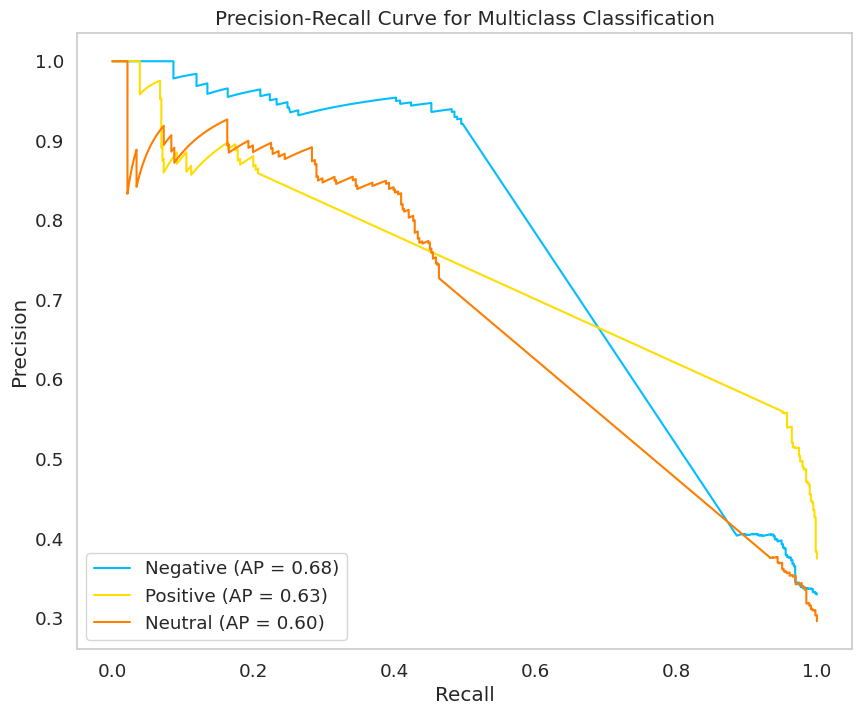

In [90]:
from sklearn.metrics import precision_recall_curve, average_precision_score
plt.figure(figsize=(10,8))

class_names = ['Negative', 'Positive', 'Neutral']
y_test_binarized = label_binarize(y_test, classes=range(len(class_names)))

for i, class_name in enumerate(class_names):
    if np.sum(y_test_binarized[:, i]) > 0 and np.sum(1 - y_test_binarized[:, i]) > 0:
        precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_probs[:, i])
        avg_precision = average_precision_score(y_test_binarized[:, i], y_pred_probs[:, i])
        plt.plot(recall, precision, label=f"{class_name} (AP = {avg_precision:.2f})")
    else:
        print(f"Skipping {class_name} because only one class is present in y_test.")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Multiclass Classification")
plt.legend(loc="lower left")
plt.grid()
plt.show()


# Roc Auc Score

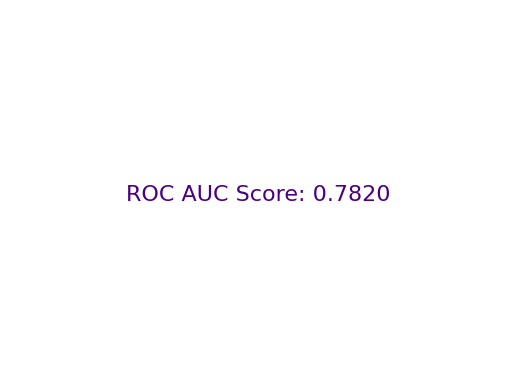

In [91]:


roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')

plt.plot([])
plt.text(0, 0, f'ROC AUC Score: {roc_auc:.4f}', fontsize=16, ha='center', va='center', color="indigo")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.show()


# Log Loss

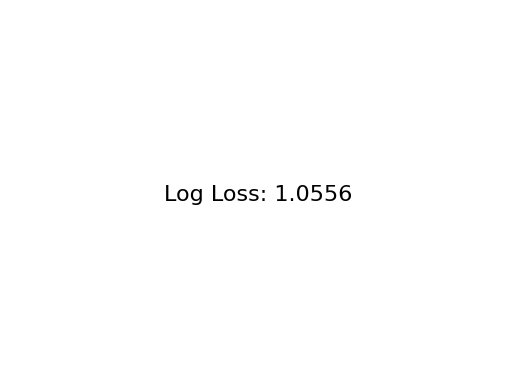

In [92]:
from sklearn.metrics import log_loss



classes = [0, 1, 2]

logarithm_loss = log_loss(y_test, y_pred_probs, labels=classes)

plt.plot([])
plt.text(0, 0, f'Log Loss: {logarithm_loss:.4f}', fontsize=16, ha='center', va='center', color="black")
plt.axis('off')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.show()


# Kappa Score

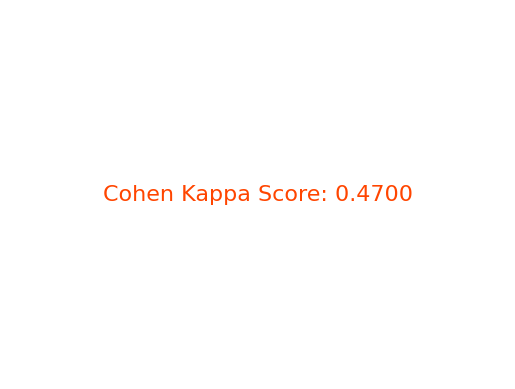

In [93]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test,y_pred)
plt.plot([])
plt.text(0,0, f'Cohen Kappa Score: {kappa:.4f}', fontsize=16, ha='center', va='center',color="orangered")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

# matthews_corrcoef 

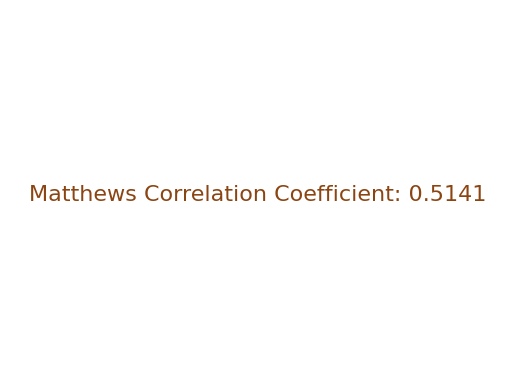

In [94]:
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test,y_pred)

# Create a plot and display the MCC value as text
plt.plot([])
plt.text(0,0, f'Matthews Correlation Coefficient: {mcc:.4f}', fontsize=16, ha='center', va='center',color="saddlebrown")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

# Model Prediction

In [95]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({'class_names': class_names,'values': y_pred_probs[idx]})

In [96]:
from textwrap import wrap
print("==============================================================================")
print("\n".join(wrap(review_text)))
print("==============================================================================")
print(f'True sentiment: {class_names[true_sentiment]}')
print("==============================================================================")

doesnt thing gliched everytime open hi apologies issue app tasks
community driven hobby project mine popular suggestions added time
offered free without advertising first report issue kind glitches look
like thanks steve
True sentiment: Negative


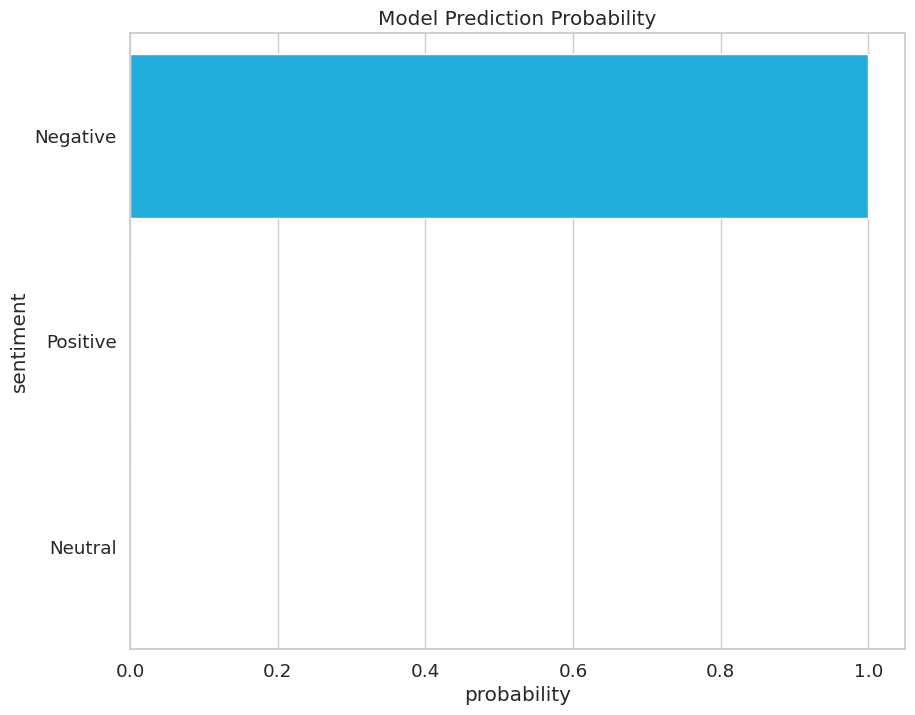

In [97]:
plt.figure(figsize=(10,8))
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.title("Model Prediction Probability")
plt.show()

# Prediction On Custom Data

In [98]:
review_text = "Every day brings a new opportunity to overcome challenges, learn from experiences, and grow stronger, as we continuously work towards becoming the best version of ourselves, embracing both successes and setbacks as stepping stones toward a brighter future"

In [99]:
encoded_review = bert_tokenizer.encode_plus(
  review_text,
  max_length=max_len,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [100]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print("==============================================================================================")
print(f'Review text: {review_text}')
print("==============================================================================================")
print(f'Sentiment  : {class_names[prediction]}')
print("==============================================================================================")

Review text: Every day brings a new opportunity to overcome challenges, learn from experiences, and grow stronger, as we continuously work towards becoming the best version of ourselves, embracing both successes and setbacks as stepping stones toward a brighter future
Sentiment  : Positive
